# Workshop 0: Introduction to Posthoc Interpretability
*Interpretability & Explainability in AI*, MSc A.I., University of Amsterdam, June 2023

## Lab 1: Probing Language Models

**Credits**: *Text and code by Jaap Jumelet (May 2022). Editing & additional questions/assignments by Jelle Zuidema. This notebook makes use of many different libraries including crucially NLTK and Hugging Face's Transformers library, and the trained weights of the RoBERTa-base model and the RoBERTa-base-SST2 version (trained by researchers of FAIR; fine-tuned for the SST-2 dataset of Stanford University, and provided by Hugging Face). RoBERTa is described in this paper: https://arxiv.org/abs/1907.11692*

### Background
NLP ultimately aims to develop systems that possess a truly comprehensive understanding of language, an understanding that is able to systematically generalise to new scenarios, based on a fundamental apprehension of the core structures of language.
Contemporary approaches adhere to an *unsupervised* paradigm, driven by enormous amounts of data, which has led to a series of breakthroughs in the field.
These successes have been supported by an exponential increase in computing power, and by using *deep learning* models such as neural networks.
However, employing neural networks comes at a great loss of transparency; while their impressive performance is commendable, it is no longer evident how these models operate.
This has given rise to a new line of research that aims to uncover the internal dynamics of these models, in a similar manner to how psycholinguistics attempts to unravel the mysteries of human language processing.

In this assignment, we will focus our investigation on **language models**.
These are models that assign a probability to the next token in a sentence, conditioned on a prior context.
To do this proficiently, they should be able to thoroughly grasp a sentence on both a syntactic and semantic level: by keeping track of information on the subject, the topic of the sentence, the action being performed, etc.
This makes these systems perfectly suited for investigating current NLP systems, as there are few tasks that require such a comprehensive understanding of language as language modelling does.

In recent years, there has been considerable interest into analysing the linguistic capacities of language models.
Most of these analyses approach language modelling from a behavioural angle, investigating a model's output behaviour on a specific linguistic phenomenon (e.g. [Gulordava et al. (2018)](https://aclanthology.org/N18-1108/) and [Marvin & Linzen (2018)](https://aclanthology.org/D18-1151/)).
This approach has yielded a substantial understanding of *what* phenomena these models understand, but does not necessarily provide clues on *how* these phenomena are processed.

### Probing
The linguistic dynamics of a language model can be assessed in several ways.
In this assignment we will focus on using **probing tasks**.
These tasks allow us to *probe* a model's representations using *diagnostic classifiers* ([Hupkes et al. (2018)](https://scholar.google.com/citations?view_op=view_citation&hl=nl&user=tAtSMTcAAAAJ&citation_for_view=tAtSMTcAAAAJ:2osOgNQ5qMEC), also simply referred to as *probes*).
Diagnostic classifiers are simple (i.e. often linear) classifiers that are trained on top of the representations of a model.
This allows us to uncover (linguistic) properties that are encoded in a representation.

Note, however, that the probing paradigm is not restricted to NLP at all, and has been applied in a wide range of application domains, such as chess, vision, and bio-informatics, as has and will be discussed in the lectures. Probing serves as a general tool of uncovering what kind of properties are encoded in the high-dimensional representations of deep neural nets.

## Assignment
In this short introductory assignment we will be probing language models for **sentiment**. Sentiment classification is a simple yet common task in NLP, and is nowadays performed as a *fine-tuning* procedure: based on a pre-trained language model we fine-tune the full model on an annotated data set containing sentiment labels. This is often done on a sentence-level, but sentiment of a sentence is the result of a compositional application of sentiment at a lexical level. 

You will train probes on the hidden states of a fine-tuned RoBERTa model, to gain insights into how sentiment is represented in these models *across layers*. You will compare these results with the probing results obtained for a *non-*fine-tuned RoBERTa model, i.e. the pre-trained language model that was originally used for fine-tuning it.

This notebook already contains a lot of code to handle the processing of the data, and the extraction of the hidden states of the model, so that you can fully focus on the probing itself.

##ToSubmit: workshop-0 report
Note: answers to the questions marked as ToSubmit (and only those!) need to be submitted as part of your (very brief) Workshop-0 report. That report is individual work, but during the workshop you are encouraged to work together and help each other.

## Configuration

Don't forget to enable the GPU runtime at the top! (Runtime -> Change runtime type)

And point add the directory in which you are running this notebook in the bottom of this cell.

In [1]:
from tqdm import *
from typing import * 

import torch
import torch.nn.functional as F 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Mount to drive so we can access our own files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# The natural language dataset

The data we will be using is the SST sentiment treebank, that also contains sentiment labels at the word-level.

<font color='green'><b>ToDo 1</b></font>

+ Create a folder IEinAI in the home directory of your Google Drive
+ Store the current notebook in that folder!
+ Download the corpus, using the following command:

In [2]:
# IMPORTANT: Point this towards the drive folder in which you have stored this notebook
%cd /content/drive/My Drive/IEinAI

!pip install gdown
# Download a drive folder containing train.txt, dev.txt, and test.txt.
# If you want to do this manually you can find the folder here:
# https://drive.google.com/drive/folders/1UbiuZbIAPq30BvVgB4wg0z6imqaSNiIa?usp=sharing
!gdown --folder 1UbiuZbIAPq30BvVgB4wg0z6imqaSNiIa

/content/drive/My Drive/IEinAI
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Retrieving folder list
Processing file 1xZveybxnJfryyg-PFLeEuhiAaovyDsa- dev.txt
Processing file 1PcNXZ-QIPvgXsxcB0IMrJiIzYBQJzS16 test.txt
Processing file 13lvRQRKt8XIRS0xtR4d_LOrHWQN44AoK train.txt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1xZveybxnJfryyg-PFLeEuhiAaovyDsa-
To: /content/drive/My Drive/IEinAI/data/dev.txt
100% 281k/281k [00:00<00:00, 87.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PcNXZ-QIPvgXsxcB0IMrJiIzYBQJzS16
To: /content/drive/My Drive/IEinAI/data/test.txt
100% 560k/560k [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=13lvRQRKt8XIRS0xtR4d_LOrHWQN44AoK
To: /content/drive/My Drive/IEinAI/data/train.txt
100% 2.16M/2.16M [00:00<00:00, 140MB/s]
Download completed


In [3]:
import nltk

def load_corpus(file_name, is_binary=True):
    with open(file_name) as f:
        raw_trees = f.readlines()

    nltk_trees = [nltk.Tree.fromstring(raw_tree) for raw_tree in raw_trees]

    token_labels = []
    raw_sentences = []
    sentence_labels = []

    for tree in nltk_trees:
        try:
            token_labels.append(extract_token_labels(tree))
            raw_sentences.append(" ".join(tree.leaves()))
            sentence_labels.append(int(tree.label()))
        except AttributeError:
            # There's a few ill-formed trees in the data, we just skip over these
            continue

    return token_labels, raw_sentences, torch.tensor(sentence_labels)


def extract_token_labels(tree):
    """Extracts the token-level sentiments from the tree, recursively. """

    if len(tree) == 1:
        # Leaf has been reached
        return [(tree[0], int(tree.label()))]
    else:
        # Recursively descend into children of current node
        return [
            (item, label)
            for subtree in tree
            for item, label in extract_token_labels(subtree)
        ]

<font color='green'><b>ToDo 2</b></font>

+ Load the corpus, e.g. with 
```
all_token_labels, all_sentences, sentence_labels = load_corpus('data/train.txt')
```
+ Look at a couple of sentences; e.g. sentence #117
+ Look at the token labels and determine which of the words have negative ($< 2$) and which have positive sentiment ($>2$).



In [4]:
# your code here
all_token_labels, all_sentences, sentence_labels = load_corpus('data/train.txt')

In [5]:
all_sentences[117] , all_sentences[13] , all_sentences[19], all_sentences[8540]

("Jeffrey Tambor 's performance as the intelligent jazz-playing exterminator is Oscar-worthy .",
 'A thunderous ride at first , quiet cadences of pure finesse are few and far between ; their shortage dilutes the potency of otherwise respectable action .',
 'If you love reading and\\/or poetry , then by all means check it out .',
 'In this case zero .')

In [7]:
# list_sent = range(20)
# for sent in list_sent:
#   for key, value in all_token_labels[sent].items():
#       if len(value) < 1:
#           print(sent)

In [6]:
list_sent = [6, 13, 15, 28, 29, 31]
for sent in list_sent:
  print(sent+1)
  for i in range(len(all_token_labels[sent])):
    if(all_token_labels[sent][i][1] < 2):
      print(str(all_token_labels[sent][i])+ ' :negative')
    elif(all_token_labels[sent][i][1] ==2):
      print(str(all_token_labels[sent][i])+ ' :neutral')
    else:
      print(str(all_token_labels[sent][i])+ ' :positive') 
  print("----------------")

7
('Just', 2) :neutral
('the', 2) :neutral
('labour', 2) :neutral
('involved', 2) :neutral
('in', 2) :neutral
('creating', 2) :neutral
('the', 2) :neutral
('layered', 3) :positive
('richness', 2) :neutral
('of', 2) :neutral
('the', 2) :neutral
('imagery', 2) :neutral
('in', 2) :neutral
('this', 2) :neutral
('chiaroscuro', 2) :neutral
('of', 2) :neutral
('madness', 2) :neutral
('and', 2) :neutral
('light', 2) :neutral
('is', 2) :neutral
('astonishing', 4) :positive
('.', 2) :neutral
----------------
14
('A', 2) :neutral
('thunderous', 3) :positive
('ride', 2) :neutral
('at', 2) :neutral
('first', 2) :neutral
(',', 2) :neutral
('quiet', 2) :neutral
('cadences', 2) :neutral
('of', 2) :neutral
('pure', 4) :positive
('finesse', 3) :positive
('are', 2) :neutral
('few', 2) :neutral
('and', 2) :neutral
('far', 2) :neutral
('between', 2) :neutral
(';', 2) :neutral
('their', 2) :neutral
('shortage', 1) :negative
('dilutes', 2) :neutral
('the', 2) :neutral
('potency', 2) :neutral
('of', 2) :neutr

In [7]:
list_sent = [117,13,19,8540, 60]
for sent in list_sent:
  for i in range(len(all_token_labels[sent])):
    if(all_token_labels[sent][i][1] < 2):
      print(str(all_token_labels[sent][i])+ ' :negative') 
    else:
      print(str(all_token_labels[sent][i])+ ' :positive') 
  print("----------------")

('Jeffrey', 2) :positive
('Tambor', 2) :positive
("'s", 2) :positive
('performance', 2) :positive
('as', 2) :positive
('the', 2) :positive
('intelligent', 3) :positive
('jazz-playing', 2) :positive
('exterminator', 2) :positive
('is', 2) :positive
('Oscar-worthy', 4) :positive
('.', 2) :positive
----------------
('A', 2) :positive
('thunderous', 3) :positive
('ride', 2) :positive
('at', 2) :positive
('first', 2) :positive
(',', 2) :positive
('quiet', 2) :positive
('cadences', 2) :positive
('of', 2) :positive
('pure', 4) :positive
('finesse', 3) :positive
('are', 2) :positive
('few', 2) :positive
('and', 2) :positive
('far', 2) :positive
('between', 2) :positive
(';', 2) :positive
('their', 2) :positive
('shortage', 1) :negative
('dilutes', 2) :positive
('the', 2) :positive
('potency', 2) :positive
('of', 2) :positive
('otherwise', 2) :positive
('respectable', 3) :positive
('action', 2) :positive
('.', 2) :positive
----------------
('If', 2) :positive
('you', 2) :positive
('love', 4) :p

<font color='red'><b>ToSubmit 1</b></font>
Include one example sentence (different from the one above) in your report, with words with negative and positive sentiment marked.

We are only interested in probing the sentiment for words that actually contain sentiment (*great, terrible, mediocre*). To ensure this, we'll create a **mask** that tells us at which positions in our corpus the sentiment words are located.

Furthermore, for the sake of simplicity we will only be considering words that are not split up into multiple subwords by the model tokenizer. (Current language models, such as the Transformer models that we look at in this Lab, make use of **subword tokenization**, which may split up a longer word into multiple subwords: `"ungrateful"` could become `"un" + "grate" + "ful"`. This makes probing a bit harder, because it's hard to tell how sentiment is distributed over these multiple subwords).

In [11]:
#@title Function to create a mask for sentiment-carrying words (needs access to model's tokenizer)

from tqdm import *

def create_sen_masks(
    input_ids, all_token_labels, tokenizer, sentiments=(0, 4), is_binary=True
):
    """Returns a mask for the sentence positions that have a negative/positive sentiment"""
    all_sen_masks = []
    all_labels = []

    for tokenised_sen, token_labels in tqdm_notebook(zip(input_ids.tolist(), all_token_labels)):
        sen_mask = []
        token_label_dict = dict(token_labels)

        for w_idx, (token_id) in enumerate(tokenised_sen):
            if token_id == 0:
                sen_mask.append(False)
                continue

            word = tokenizer.convert_ids_to_tokens(token_id).replace("Ġ", "")
            if token_label_dict.get(word, -1) in sentiments:
                sen_mask.append(True)
                label = token_label_dict[word]
                if is_binary:
                    label = label > 2
                all_labels.append(label)
            else:
                sen_mask.append(False)

        all_sen_masks.append(torch.tensor(sen_mask))

    padded_masks = torch.nn.utils.rnn.pad_sequence(all_sen_masks, batch_first=True)

    return padded_masks, torch.tensor(all_labels)

# Loading the target models

For loading the models we will be making use of Huggingface's transformer library, that has become the de facto standard for transformer models within NLP.

In [12]:
!pip install transformers

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification


def load_model(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    model = AutoModelForSequenceClassification.from_pretrained(path)
    model.eval()
    model.to(DEVICE)

    return model, tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.2 MB/s eta 0:00:00


## Hidden state extraction

The final step now is to actually extract the hidden states from the language models. We will store these in two separate dictionaries: 
- One containing the sentence-level hidden states (at the position of the special `CLS` token, on which the model was fine-tuned)
- One containing the token-level hidden states, filtered by the mask that we created in the previous cell.

Both these dictionaries contain the hidden states at each intermediate layer, starting at the bottom (these are just the input word embeddings), all the way to the top layer.

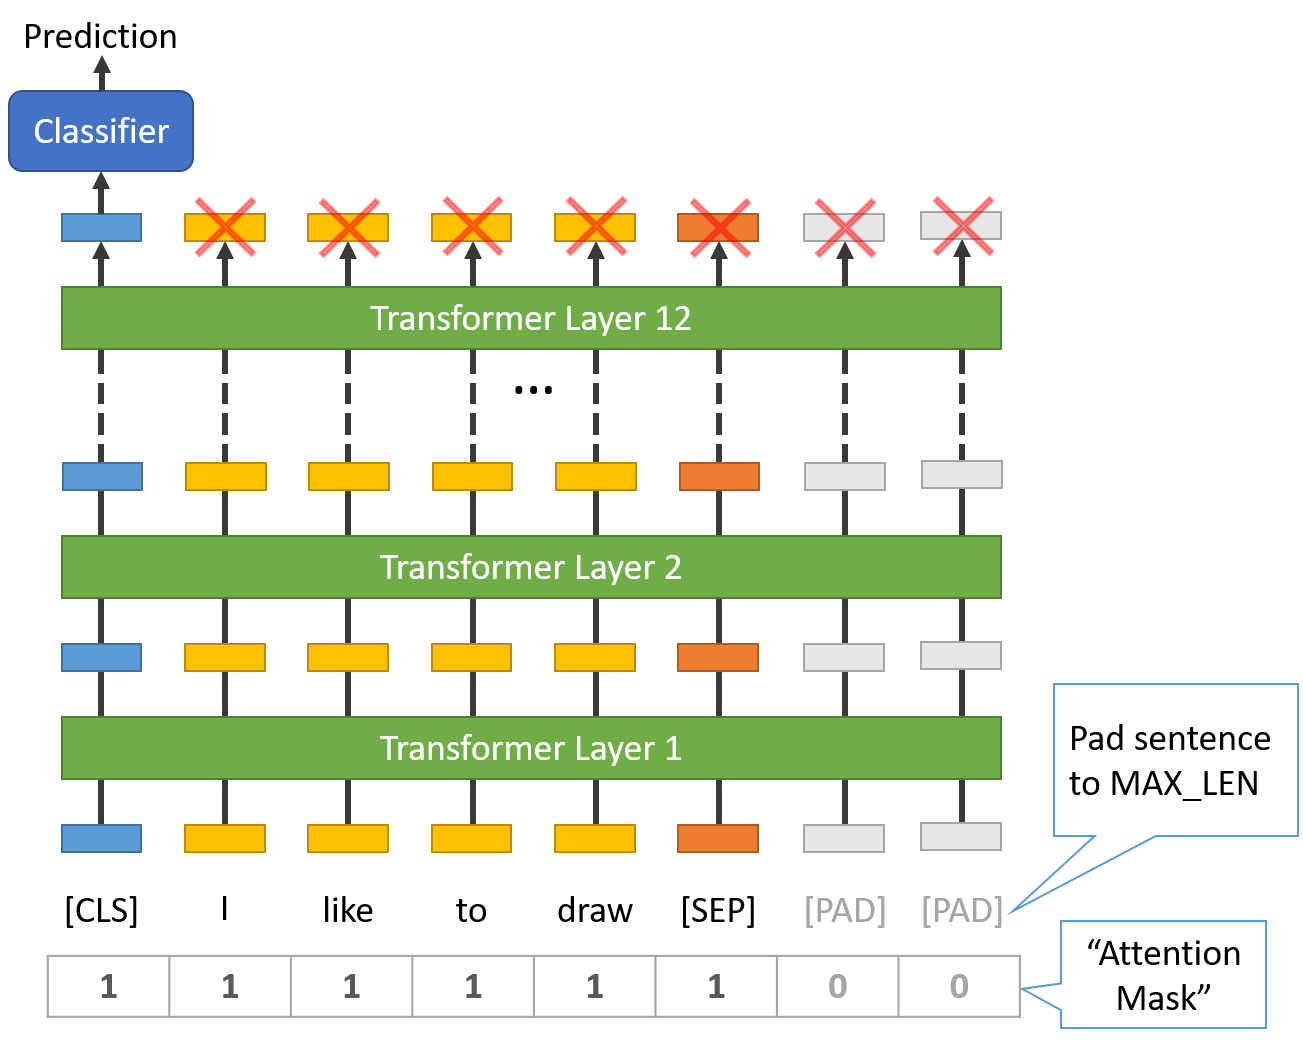

<font color='blue'><b>ToThink 1</b></font>
In the diagram above you see a sketch of the typical Transformer setup for sentence classifications. As indicated, the CLS token in the output layer is typically used to determine the class (e.g. the sentiment class) of the whole sentence. Which other hidden states would be interesting targets for probing?

In [13]:
#@title Key functions for extracting the hidden states (for a given set of sentences)

def extract_hidden_states(
    input_ids, attention_mask, all_sen_masks, num_layers, batch_size=128
):
    token_states = {
        layer_idx: torch.zeros(all_sen_masks.sum(), 768)
        for layer_idx in range(num_layers)
    }

    cls_states = {
        layer_idx: torch.zeros(all_sen_masks.size(0), 768)
        for layer_idx in range(num_layers)
    }

    dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, all_sen_masks)
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False
    )

    num_extracted = 0
    sens_extracted = 0
    layer_idx = 0

    for batch_input_ids, batch_attention_mask, batch_sen_mask in tqdm_notebook(
        data_loader, unit="batches"
    ):
        with torch.no_grad():
            all_hidden_states = model(
                batch_input_ids,
                attention_mask=batch_attention_mask,
                output_hidden_states=True,
            ).hidden_states

        for layer_idx, hidden_states in enumerate(all_hidden_states):
            hidden_states_subset = hidden_states[batch_sen_mask]
            subset_size = hidden_states_subset.shape[0]

            token_states[layer_idx][
                num_extracted : num_extracted + subset_size
            ] = hidden_states_subset.cpu()

            cls_states[layer_idx][
                sens_extracted : sens_extracted + batch_size
            ] = hidden_states[:, 0].cpu()

        num_extracted += subset_size
        sens_extracted += batch_size

    return token_states, cls_states

Finally, we create a method that ties all the previous steps together, and that will return the hidden states (on sentence & word level), and the corresponding labels. We will be storing these states and labels in a `data_dict` dictionary object, that contains the data for both the fine-tuned model and the base model.

The original data contains five classes of fine-grained sentiment (including a neutral sentiment, '2'). This fine-grained task is much harder than the binary task, as can be seen in these leaderboards:
- [Binary leaderboard](https://paperswithcode.com/sota/sentiment-analysis-on-sst-2-binary)
- [Fine-grained leaderboard](https://paperswithcode.com/sota/sentiment-analysis-on-sst-5-fine-grained)

We can therefore opt to binarise these labels: i.e. mapping 0 & 1 to a negative label, and 3 & 4 to a positive label. <font color='red'>Please implement this step yourself in the cell below.</font> 

----

In [14]:
#@title Key functions for creating the probing datasets
def preprocess_cls_data(
    cls_states: Dict[int, torch.Tensor], sentence_labels: torch.Tensor, is_binary: bool
):
    # Remove neutral sentences
    for layer_idx, layer_states in cls_states.items():
        cls_states[layer_idx] = layer_states[sentence_labels != 2]

    sentence_labels = sentence_labels[sentence_labels != 2]

    # Map fine-grained sentiments to binary labels
    if is_binary:
      labels = []
      for label in sentence_labels:
        if((label == 0) | (label == 1)):
          labels.append(0) #negative
        elif((label == 3) | (label == 4)):
          labels.append(1) #positive

      sentence_labels = labels

    # raise NotImplementedError

    return cls_states, sentence_labels


def create_probe_data(path, model, tokenizer, num_layers, sentiments, is_binary):
    all_token_labels, all_sentences, sentence_labels = load_corpus(path)

    encoded_corpus = tokenizer(
        all_sentences,
        padding=True,
        truncation=True,
        return_tensors="pt",
    ).to(DEVICE)

    input_ids = encoded_corpus.input_ids
    attention_mask = encoded_corpus.attention_mask

    all_sen_masks, token_labels = create_sen_masks(
        input_ids,
        all_token_labels,
        tokenizer,
        sentiments=sentiments,
        is_binary=is_binary,
    )

    token_states, cls_states = extract_hidden_states(
        input_ids, attention_mask, all_sen_masks, num_layers
    )

    cls_states, sentence_labels = preprocess_cls_data(cls_states, sentence_labels, is_binary)

    return token_states, cls_states, token_labels, sentence_labels

<font color='green'><b>ToDo 3</b></font>

+ Download the Transformer library and the two target Transformer models, and run the hidden state extraction code;
+ Or: download a file that contains all the RoBERTa hidden states that we will be using.
+ Look at some examples of the hidden state tensors download or computed.

In [15]:
#@title Compute and store internal states (Note that running this cell may take a few minutes (and again, make sure GPU is enabled!))

sentiments = (0, 1, 3, 4)
is_binary = True

models = [
    ("finetuned", "textattack/roberta-base-SST-2"),
    ("base", "roberta-base"),
]

data_dict = {}


for name, path in models:
    model, tokenizer = load_model(path)

    num_layers = len(model.roberta.encoder.layer) + 1

    train_X, cls_train_X, train_y, cls_train_y = create_probe_data(
        "data/train.txt", model, tokenizer, num_layers, sentiments, is_binary
    )
    test_X, cls_test_X, test_y, cls_test_y = create_probe_data(
        "data/test.txt", model, tokenizer, num_layers, sentiments, is_binary
    )

    data_dict[name] = {
        "train_X": train_X,  # Dictionary mapping layer_idx -> tensor 
        "train_y": train_y,
        "test_X": test_X,
        "test_y": test_y,
        "cls_train_X": cls_train_X,
        "cls_train_y": cls_train_y,
        "cls_test_X": cls_test_X,
        "cls_test_y": cls_test_y,
    }


Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-11-9230f783091f>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tokenised_sen, token_labels in tqdm_notebook(zip(input_ids.tolist(), all_token_labels)):


0it [00:00, ?it/s]

<ipython-input-13-17a5469cf332>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_input_ids, batch_attention_mask, batch_sen_mask in tqdm_notebook(


  0%|          | 0/67 [00:00<?, ?batches/s]

0it [00:00, ?it/s]

  0%|          | 0/18 [00:00<?, ?batches/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

0it [00:00, ?it/s]

  0%|          | 0/67 [00:00<?, ?batches/s]

0it [00:00, ?it/s]

  0%|          | 0/18 [00:00<?, ?batches/s]

Instead of extracting the hidden states manually, you can also download them directly by running the following cell:

In [16]:
#@title Download and store precomputed hidden states
# Stores the hidden states as a data_dict.pt file. 
!gdown 1vFNdE6iHguHoddWbj640w7DRQSkY8F-c

# In case gdown gives an error (this happens if too many people download it), you can also try the following:
# !wget -O data_dict.pt https://surfdrive.surf.nl/files/index.php/s/9RLi10OFNIxzIhf/download

data_dict = torch.load("data_dict.pt")

Downloading...
From: https://drive.google.com/uc?id=1vFNdE6iHguHoddWbj640w7DRQSkY8F-c
To: /content/drive/MyDrive/IEinAI/data_dict.pt
100% 2.47G/2.47G [00:28<00:00, 85.9MB/s]




---



## Probing

We have now come to the core of the assignment. The first goal is to probe the sentence-level (`CLS`) states of our model. For the probes you can make use of the `LogisticRegression` class of the `sklearn` module, but a different linear classifier of your liking is fine as well.

You will train a probes on all the intermediate layers as well (that is, a separate probe for each layer, don't train a single probe on all layers at once).

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings

warnings.filterwarnings("ignore")


num_layers=12

cls_probes = {
    model_name: {
        layer_idx: LogisticRegression(solver="liblinear", penalty="l2", max_iter=10)
        for layer_idx in range(num_layers)
    }
    for model_name in data_dict.keys()
}

cls_probe_results = {
    model_name: []
    for model_name in data_dict.keys()
}

for model_name in cls_probes.keys():
    for layer_idx in range(num_layers):
        # Skip neutral sentence and binarise sentiment classification
        train_X, train_y = (
            data_dict[model_name]["cls_train_X"][layer_idx], 
            data_dict[model_name]["cls_train_y"]
        )

        cls_probes[model_name][layer_idx].fit(train_X, train_y)

        test_X, test_y = (
            data_dict[model_name]["cls_test_X"][layer_idx], 
            data_dict[model_name]["cls_test_y"]
        )

        test_pred = cls_probes[model_name][layer_idx].predict(test_X)
        test_acc = accuracy_score(test_pred, test_y)

        cls_probe_results[model_name].append(test_acc)

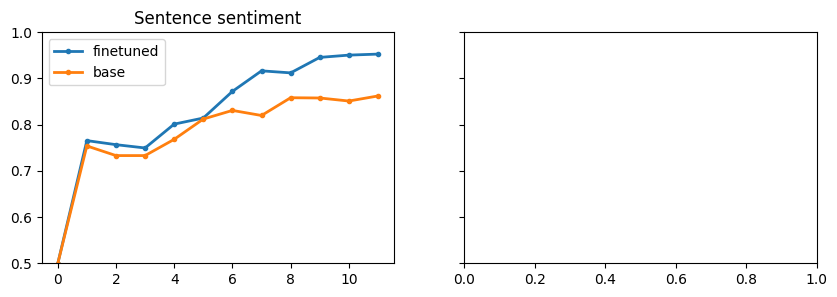

In [18]:
#@title Plotting these results

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,3))

for model_name, results in cls_probe_results.items():
    axes[0].plot(results, 'o-', lw=2, markersize=3, label=model_name)

axes[0].legend()
axes[0].set_ylim(0.5,1.0)
axes[0].set_title("Sentence sentiment")

plt.show()

<font color='blue'><b>ToThink 2</b></font>
What differences do you observe between the fine-tuned model and the base model in the results above that do sentence-level probing (i.e. that probe at the CLS node of the output layer?)

<font color='green'><b>ToDo 4:</b></font>

Now, let's probe for the lexical sentiment. The setup will same as for the `CLS` probe, but now with the word-level hidden states and labels.

(i.e. you need to adapt the code above, such that you do not read ```cls_train_x``` etc from the probing dataset, but read the internal states from nodes for sentiment-carrying words instead).

In [19]:
## Your code for probing the word-level states


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings

warnings.filterwarnings("ignore")


num_layers=12

cls_probes = {
    model_name: {
        layer_idx: LogisticRegression(solver="liblinear", penalty="l2", max_iter=10)
        for layer_idx in range(num_layers)
    }
    for model_name in data_dict.keys()
}

cls_probe_results = {
    model_name: []
    for model_name in data_dict.keys()
}

for model_name in cls_probes.keys():
    for layer_idx in range(num_layers):
        # Skip neutral sentence and binarise sentiment classification
        train_X, train_y = (
            data_dict[model_name]["train_X"][layer_idx], 
            data_dict[model_name]["train_y"]
        )

        cls_probes[model_name][layer_idx].fit(train_X, train_y)

        test_X, test_y = (
            data_dict[model_name]["test_X"][layer_idx], 
            data_dict[model_name]["test_y"]
        )

        test_pred = cls_probes[model_name][layer_idx].predict(test_X)
        test_acc = accuracy_score(test_pred, test_y)

        cls_probe_results[model_name].append(test_acc)

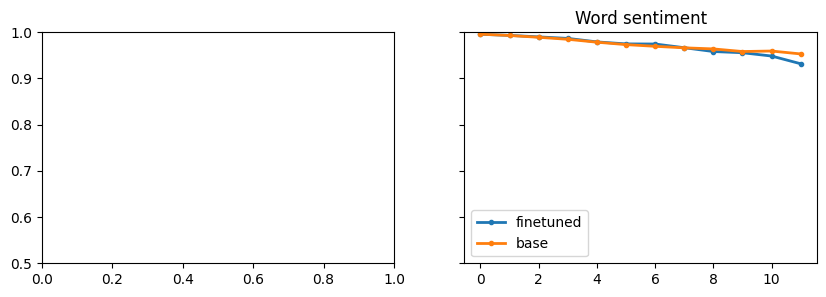

In [20]:
#@title Plotting these results

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,3))

for model_name, results in cls_probe_results.items():
    axes[1].plot(results, 'o-', lw=2, markersize=3, label=model_name)

axes[1].legend()
axes[1].set_ylim(0.5,1.0)
axes[1].set_title("Word sentiment")

plt.show()

<font color='red'><b>ToSubmit 2:</b></font>

Include a plot in your Workshop-0 Report that shows both the sentence-level (CLS) and the word-level probing results.

<font color='blue'><b>ToThink 3</b></font>

What differences do you observe between the fine-tuned model and the base model?

Finally, we can also use a probe that has been trained on one type of representation (e.g. on `layer #3`), and evaluate that probe on a different representation (e.g. that of `layer #9`). 



```
cross_pred = probes["base"][3].predict(data_dict["base"]["test_X"][9])
accuracy_score(cross_pred, data_dict["base"]["test_y"])
```

This gives us insights into how the representation of a property changes across the model: if this is fairly stable cross-evaluating `probe/layer #3` on `layer #9` would give somewhat similar accuracy as evaluating it on `layer #3`.

This idea has been applied earlier by [Giulianelli et al. (2018)](https://arxiv.org/pdf/1808.08079.pdf), in the Temporal Generalization Matrices of Figures 3 and 4, where crossaccuracy across hidden layer activation at different timesteps is computed (whereas here we compute crossaccuracy across different layers).



<font color='green'><b>ToDo 5:</b></font>

Write the code for computing cross-layer accuracy for all combinations of layers.

In [21]:
## Your code for computing the cross-layer accuracy
acc_score_list = []
for i in range(12):
  acc_list = []
  for j in range(12):
    cross_pred = cls_probes["base"][i].predict(data_dict["base"]["test_X"][j])
    acc = accuracy_score(cross_pred, data_dict["base"]["test_y"])
    acc_list.append(round(acc, 2))
  acc_score_list.append(acc_list)


In [22]:
acc_score_list

[[1.0, 0.91, 0.76, 0.71, 0.72, 0.71, 0.69, 0.68, 0.68, 0.68, 0.67, 0.67],
 [0.95, 0.99, 0.98, 0.95, 0.93, 0.92, 0.9, 0.89, 0.87, 0.86, 0.84, 0.81],
 [0.94, 0.98, 0.99, 0.96, 0.93, 0.91, 0.9, 0.88, 0.85, 0.85, 0.83, 0.81],
 [0.94, 0.96, 0.98, 0.98, 0.96, 0.95, 0.93, 0.92, 0.89, 0.86, 0.86, 0.84],
 [0.91, 0.96, 0.96, 0.96, 0.98, 0.96, 0.95, 0.93, 0.9, 0.88, 0.87, 0.85],
 [0.83, 0.93, 0.95, 0.96, 0.97, 0.97, 0.95, 0.93, 0.91, 0.9, 0.87, 0.86],
 [0.77, 0.92, 0.95, 0.96, 0.95, 0.96, 0.97, 0.95, 0.93, 0.92, 0.9, 0.87],
 [0.86, 0.92, 0.94, 0.95, 0.95, 0.96, 0.95, 0.97, 0.95, 0.92, 0.87, 0.83],
 [0.86, 0.91, 0.93, 0.94, 0.94, 0.94, 0.95, 0.95, 0.96, 0.95, 0.92, 0.9],
 [0.85, 0.85, 0.9, 0.93, 0.94, 0.94, 0.95, 0.95, 0.95, 0.96, 0.94, 0.92],
 [0.87, 0.83, 0.9, 0.91, 0.91, 0.92, 0.94, 0.93, 0.94, 0.95, 0.96, 0.94],
 [0.89, 0.9, 0.93, 0.94, 0.93, 0.93, 0.93, 0.93, 0.94, 0.94, 0.95, 0.95]]

In [23]:
num_layers

12

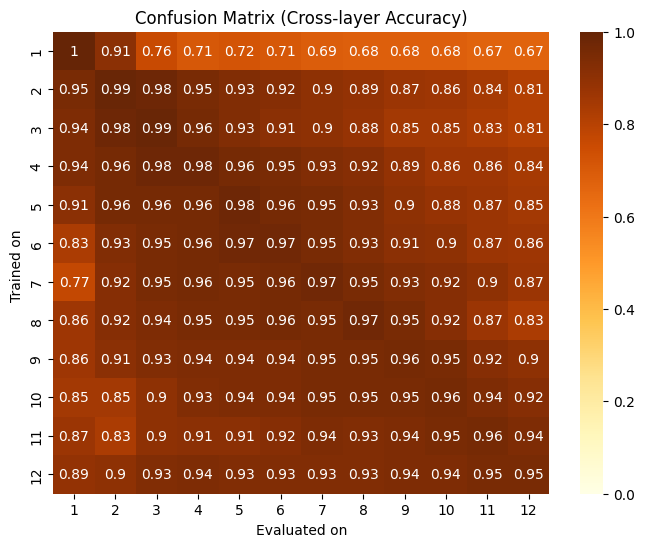

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Plotting the confusion matrix as a heat map
plt.figure(figsize=(8, 6))
sns.heatmap(acc_score_list, annot=True, cmap="YlOrBr", vmin=0, vmax=1)
plt.xlabel("Evaluated on")
plt.ylabel("Trained on ")
plt.title("Confusion Matrix (Cross-layer Accuracy)")
plt.xticks(np.arange(num_layers) + 0.5, range(1, 13))
plt.yticks(np.arange(num_layers) + 0.5, range(1, 13))
plt.show()

<font color='blue'><b>ToThink 4:</b></font>

How does the representation of sentiment evolve across the layers? What differences do you observe between base and fine-tuned models?

<font color='red'><b>ToSubmit 3:</b></font>
Include in your report a plot of the cross-accuracy matrix: the matrix that gives for each combination of layers $<i,j>$ the accuracy of a probe trained on layer $i$ when trying to predict the sentiment at layer $j$. Write a brief caption to the figure that explains in two or three sentences how you intepret the observed pattern of results.

<font color='blue'><b>ToThink 5:</b></font>

1. **Is lexical sentiment better represented linearly in a fine-tuned model than in its base, pre-trained version? How does this compare to sentence-level sentiment?**
2. **Is sentiment information represented stably across layers?**